In [17]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.transforms as transforms
import subprocess
import astropy.units as u
from astropy.table import Table
from synphot import SpectralElement, Empirical1D, SourceSpectrum, Observation
import re

import os
gd_folder = os.getcwd()+"/../../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

sys.path.append("../utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Use the latex font when plotting. 
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
#Load the properties of the BHDs
op = ObjectProperties()

In [4]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [5]:
#Load the spectra for each BHD, extended using the best-fit SED.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [6]:
theta_angles = np.arange(0., 90., 2.5)
psi_angles = np.arange(0., 90., 2.5)

In [7]:
#Calculate the max polarization for every combination of parameters, for FWBW and just BW.
for fwbw in ([True, True], [False, True]):

    print(fwbw)
    fw, bw = fwbw

    prefix = ""
    if fw:
        prefix += "FW"
    if bw: 
        prefix += "BW"
    fname = "table_max_pols.{}.fits".format(prefix)
    if not os.path.exists(fname):
        max_pols = Table()
        max_pols.meta['comments'] = "fw: {} bw: {}".format(fw, bw)
        for wid in op.wids:
            for band in op.filters[wid]:
                for medium_type in ["SMC", "LMC", "MW"]:
                    pw = PolWaveDust(medium_type,fw=fw,bw=bw)
                    p_bb = pw.p_bb(bands.bp[band], theta_angles, psi_angles, specs.lam_obs[wid], specs.flam[wid], specs.specs.sp[wid].zspec)

                    i, j = np.unravel_index(np.argmax(p_bb, axis=None), p_bb.shape)
                    if "wid" not in max_pols.colnames:
                        max_pols["wid"]   = [wid]
                        max_pols["band"]  = [band]
                        max_pols["dust"]  = [medium_type]
                        max_pols["theta"] = theta_angles[i]
                        max_pols["psi"]   = psi_angles[j]
                        max_pols["pmax"]  = 100*np.max(p_bb)
                    else:
                        max_pols.add_row((wid, band, medium_type, theta_angles[i], psi_angles[j], 100*np.max(p_bb)))

                    
                    #print(wid, band, medium_type, theta_angles[i], psi_angles[j], 100*np.max(p_bb))

        max_pols.write("table_max_pols.{}.fits".format(prefix))

[True, True]
[False, True]


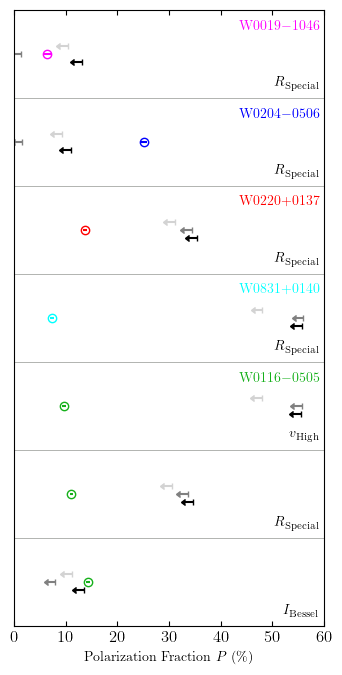

In [27]:
max_pols = Table.read("table_max_pols.fwbw.fits")

band_latex_name = {
    "R_SPECIAL": r"$R_{\rm Special}$",
    "I_BESS": r"$I_{\rm Bessel}$",
    "v_HIGH": r"$v_{\rm High}$",
}

fig, ax = plt.subplots(1, figsize=(4,8))
ax.tick_params(axis="both", direction="in", labelsize=12, bottom=True, top=True, left=False, right=False)
ax.set_yticks([])

ax.set_xlim([0, 60.])
ax.set_ylim(ax.get_xlim())

dust_colors = {
    "SMC": "black",
    "LMC": "gray",
    "MW" : "lightgray",
}

colors = {"W0116-0505":"xkcd:green", "W0019-1046":"magenta", "W0204-0506":"blue", "W0220+0137":"red", "W0831+0140":"cyan"}

#Draw the measured polarization fractions. There are 5 objects, 4 in 1 band and 1 in 3 bands. So a total of 7 measurements. 
dy = (ax.get_ylim()[1]-ax.get_ylim()[0])/7.
y = ax.get_ylim()[1] - dy/2.
for wid in op.wids:
    obj_name = re.sub("-","$-$",wid)
    #ax.text(ax.get_xlim()[1]-16, y+dy/2-1.0, wid, ha='left', va='top', fontsize=10)#, color=colors[wid])
    ax.text(ax.get_xlim()[1]-1, y+dy/2-1.0, r"{}".format(obj_name), ha='right', va='top', fontsize=10, color=colors[wid])
    #ax.text(ax.get_xlim()[0]+1, y+dy/2-1.0, r"{}".format(obj_name), ha='left', va='top', fontsize=10)#, color=colors[wid])
    for band in ["v_HIGH", "R_SPECIAL", "I_BESS"]:
        if band not in op.filters[wid]:
            continue
        ax.errorbar([op.pfrac[wid][band]], [y], xerr=[op.epfrac[wid][band]], marker='o', mfc='none', color=colors[wid])

        #label = r"{} {}".format(wid, band_latex_name[band])
        #ax.text(op.pfrac[wid][band], y-dy/4, label, color=colors[wid])
        ax.text(ax.get_xlim()[1]-1, y-dy/2+2.0, band_latex_name[band], ha='right', va='top', fontsize=10)#, color=colors[wid])

        offset = -0.8
        for dust in ["SMC","LMC","MW"]:
            mxp = max_pols[(max_pols["wid"]==wid) & (max_pols["band"]==band) & (max_pols["dust"]==dust)]
            #ax.arrow(mxp['pmax'],y,-2.5,0,color=color[dust], head_width=1.0)
            ax.errorbar(mxp['pmax'],y+offset,xerr=[1.5], xuplims=True, color=dust_colors[dust], symbol=None, capsize=2.0)
            offset += 0.8


        ax.plot(ax.get_xlim(), [y-dy/2,y-dy/2], 'k-', lw=0.5, color='xkcd:gray')

        y -= dy

ax.set_xlabel("Polarization Fraction $P~(\%)$")

plt.show()

In [31]:
max_pols = Table.read("table_max_pols.fwbw.fits")
max_pols['pmax'].format = '%.2f'
max_pols.show_in_notebook()

idx,wid,band,dust,theta,psi,pmax
0,W0019-1046,R_SPECIAL,SMC,87.5,0.0,13.08
1,W0019-1046,R_SPECIAL,LMC,55.0,0.0,1.44
2,W0019-1046,R_SPECIAL,MW,87.5,0.0,10.49
3,W0204-0506,R_SPECIAL,SMC,87.5,0.0,10.97
4,W0204-0506,R_SPECIAL,LMC,82.5,0.0,1.61
5,W0204-0506,R_SPECIAL,MW,80.0,0.0,9.29
6,W0220+0137,R_SPECIAL,SMC,87.5,0.0,35.35
7,W0220+0137,R_SPECIAL,LMC,87.5,0.0,34.35
8,W0220+0137,R_SPECIAL,MW,87.5,0.0,31.13
9,W0831+0140,R_SPECIAL,SMC,87.5,0.0,55.67


In [32]:
max_pols = Table.read("table_max_pols.bw.fits")
max_pols['pmax'].format = '%.2f'
max_pols.show_in_notebook()

idx,wid,band,dust,theta,psi,pmax
0,W0019-1046,R_SPECIAL,SMC,35.0,0.0,14.73
1,W0019-1046,R_SPECIAL,LMC,37.5,0.0,24.00
2,W0019-1046,R_SPECIAL,MW,37.5,0.0,14.07
3,W0204-0506,R_SPECIAL,SMC,37.5,0.0,12.33
4,W0204-0506,R_SPECIAL,LMC,40.0,0.0,20.06
5,W0204-0506,R_SPECIAL,MW,40.0,0.0,11.94
6,W0220+0137,R_SPECIAL,SMC,82.5,0.0,36.09
7,W0220+0137,R_SPECIAL,LMC,87.5,0.0,34.58
8,W0220+0137,R_SPECIAL,MW,87.5,0.0,31.11
9,W0831+0140,R_SPECIAL,SMC,87.5,0.0,55.89


In [56]:
medium_type = "SMC"
fw = True
bw = True
wid = "W0116-0505"
lam = bands.bp['I_BESS'].barlam()/(1+specs.specs.sp[wid].zspec)
pw = PolWaveDust(medium_type,fw=fw,bw=bw)
#lam  = 1800.*u.AA
psi = 10.
eta = 90.
s1 = pw.s1(([lam.value], [eta], [psi]))
eps = 0.006
2 * eps * np.cos(psi*u.deg)/s1, lam, pw.p(([lam.value], [eta], [psi]))

#self.s1 = RegularGridInterpolator((self.wave_grid, self.theta_grid, self.psi_grid), self.s1_grid, bounds_error=False, fill_value=None, method=interp_method)

(<Quantity [1.19805382e+22]>,
 <Quantity 1899.29867261 Angstrom>,
 array([0.11318621]))

In [59]:
medium_type = "LMC"
fw = True
bw = True
wid = "W0204-0506"
lam = bands.bp['R_SPECIAL'].barlam()/(1+specs.specs.sp[wid].zspec)
pw = PolWaveDust(medium_type,fw=fw,bw=bw)
#lam  = 1800.*u.AA
psi = 10.
eta = 90.
s1 = pw.s1(([lam.value], [eta], [psi]))
eps = 0.013
2 * eps * np.cos(psi*u.deg)/s1, lam, pw.p(([lam.value], [eta], [psi]))

(<Quantity [2.36109341e+22]>,
 <Quantity 2097.63974202 Angstrom>,
 array([0.00346736]))

In [64]:
medium_type = "LMC"
fw = False
bw = True
wid = "W0204-0506"
lam = bands.bp['R_SPECIAL'].barlam()/(1+specs.specs.sp[wid].zspec)
pw = PolWaveDust(medium_type,fw=fw,bw=bw)
#lam  = 1800.*u.AA
psi = 10.
eta = 40.
s1 = pw.s1(([lam.value], [eta], [psi]))
eps = 0.013
2 * eps * np.cos(psi*u.deg)/s1, lam, pw.p(([lam.value], [eta], [psi]))

(<Quantity [8.44385967e+22]>,
 <Quantity 2097.63974202 Angstrom>,
 array([-0.20941798]))